# SOCR MLB Heights & Weights Analysis

## Dataset Description & Analysis Objectives

From [the Wiki](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights): "The dataset below contains 1035 records of heights and weights for some current and recent Major League Baseball (MLB) Players."

The data were obtained from several different sources (IBM Many Eyes and two studies from 2008). One of the studies compares historical trends of the variables present in the dataset across a span greater than 100 years (1869 to 1983). It is unclear within the scope of this analysis how the average of the variables has changed over this span (e.g. height; the human species has grown taller over the course of its existence). I don't expect to be so rigorous in this analysis as to require such an investigation.

The scope of this analysis will be kept to basic analysis techniques - to gain insights from the data, rather than create any kind of prediction, and perhaps run some simple statistical tests.

## Getting the Data

The data is held in a table on an HTML. Perhaps this data is held in a more immediately useable format on the SOCR homepage (in a CSV, for example) but for the purposes of practicing foundations, we will scrape this dataset from the HTML into a pandas DataFrame.

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp

In [2]:
# get page as soup object
r = requests.get('http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights').content
soup = bs(r)

In [3]:
# get table object from soup
table = soup.find('table', attrs={'class': 'wikitable'})
# get headers (except name index)
headers = [item.get_text(strip=True) for item in table.find('tr').select('th')][1:]

In [4]:
# get text data
table_data = [[td.get_text(strip=True) for td in tr.select('td')] for tr in table.select('tr')[1:]]

In [5]:
# extract names (index)
pd_table_data = np.array(table_data).T
name_index = pd_table_data[0]
# prepare data for dataframe
pd_table_data = pd_table_data[1:]
pd_table_data = pd_table_data.T

In [6]:
# create dataframe
df = pd.DataFrame(data=pd_table_data, columns=headers, index=name_index)
df.head()

,Team,Position,Height(inches),Weight(pounds),Age
Adam_Donachie,BAL,Catcher,74,180,22.99
Paul_Bako,BAL,Catcher,74,215,34.69
Ramon_Hernandez,BAL,Catcher,72,210,30.78
Kevin_Millar,BAL,First_Baseman,72,210,35.43
Chris_Gomez,BAL,First_Baseman,73,188,35.71


## Preparing Data

We have numerical data, but currently, it's represented as a string (scraped as text from a website). Let's convert numerical values to floats.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, Adam_Donachie to Josh_Kinney
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Team            1034 non-null   object
 1   Position        1034 non-null   object
 2   Height(inches)  1034 non-null   object
 3   Weight(pounds)  1034 non-null   object
 4   Age             1034 non-null   object
dtypes: object(5)
memory usage: 48.5+ KB


Height, Weight, and Age should all be numerical.

An initial attempt to convert the values as float resulted in an error:
`ValueError: could not convert string to float: ''`

There's a null value in the data.

In [8]:
# get rows with null string values
df.loc[(df['Height(inches)'] == '') | (df['Weight(pounds)'] == '') | (df['Age'] == '')]

,Team,Position,Height(inches),Weight(pounds),Age
Kirk_Saarloos,CIN,Starting_Pitcher,72,,27.77


There's only one entry with a null value. We could drop this, but we can also do a quick google search for his weight. It's harder to get an exact weight at 27.77 years, but it should be a good enough approximation.

According to a cursory search, Kirk is 185 lbs.

In [9]:
# update null value
df.at['Kirk_Saarloos', 'Weight(pounds)'] = '185'

In [10]:
# sanity check
df.loc['Kirk_Saarloos']

Team                           CIN
Position          Starting_Pitcher
Height(inches)                  72
Weight(pounds)                 185
Age                          27.77
Name: Kirk_Saarloos, dtype: object

In [11]:
# convert float types
numer_cols = ['Height(inches)', 'Weight(pounds)', 'Age']
for col in numer_cols:
    df[col] = df[col].astype(float)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, Adam_Donachie to Josh_Kinney
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Team            1034 non-null   object 
 1   Position        1034 non-null   object 
 2   Height(inches)  1034 non-null   float64
 3   Weight(pounds)  1034 non-null   float64
 4   Age             1034 non-null   float64
dtypes: float64(3), object(2)
memory usage: 80.8+ KB


Much better. Everything looks in order.

## EDA (Exploratory Data Analysis)

Let's take a look at the data and see what we can determine.

- What do the distributions look like for each feature?
- Are there any outliers?
- Do the features correlate? How so?

### Distributions

In [13]:
# breakdown for numerical values
df.describe()

,Height(inches),Weight(pounds),Age
count,1034.000000,1034.000000,1034.000000
mean,73.697292,201.673114,28.736712
std,2.305818,20.987746,4.320310
min,67.000000,150.000000,20.900000
25%,72.000000,187.000000,25.440000
50%,74.000000,200.000000,27.925000
75%,75.000000,215.000000,31.232500
max,83.000000,290.000000,48.520000


In [14]:
# breakdown of members per team
df['Team'].value_counts().describe()

count    30.000000
mean     34.466667
std       2.012604
min      28.000000
25%      33.000000
50%      35.000000
75%      36.000000
max      38.000000
Name: Team, dtype: float64

In [15]:
# count of players by position category
df['Position'].value_counts()

Relief_Pitcher       315
Starting_Pitcher     221
Outfielder           194
Catcher               76
Second_Baseman        58
First_Baseman         55
Shortstop             52
Third_Baseman         45
Designated_Hitter     18
Name: Position, dtype: int64

Numbers are nice and all, but let's visualize them!

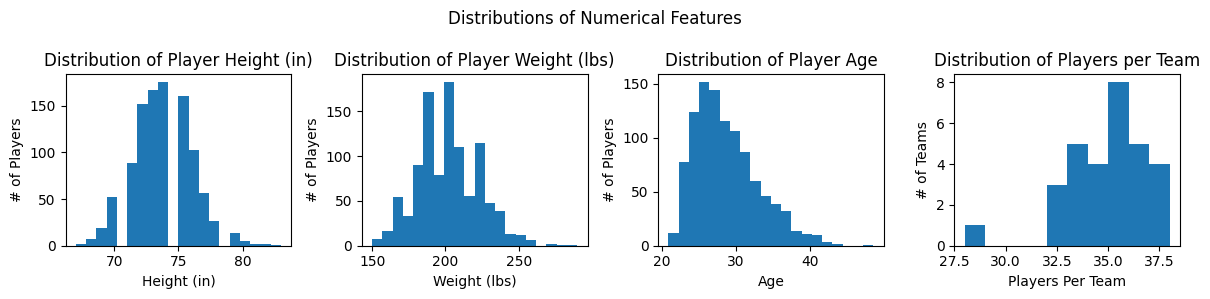

In [16]:
# visualizing counts of numerical features (and count of players by team)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# WITH SEABORN
# sns.set_style('whitegrid')
# sns.histplot(ax=axs[0], data=df['Height(inches)'], bins=20)
# sns.histplot(ax=axs[1], data=df['Weight(pounds)'], bins=20)
# sns.histplot(ax=axs[2], data=df['Age'], bins=30)
# sns.histplot(ax=axs[3], data=df['Team'].value_counts(), bins=10)

# pass data to charts
axs[0].hist(df['Height(inches)'], bins=20)
axs[1].hist(df['Weight(pounds)'], bins=20)
axs[2].hist(df['Age'], bins=20)
axs[3].hist(df['Team'].value_counts(), bins=10)

# set labels, titles
ax_titles = ['Height (in)', 'Weight (lbs)', 'Age', 'Players Per Team']
for i in range(4):
    axs[i].set_xlabel(ax_titles[i])
for i in range(3):
    axs[i].set_ylabel('# of Players')
    axs[i].set_title(f'Distribution of Player {ax_titles[i]}')
axs[3].set_ylabel('# of Teams')
axs[3].set_title('Distribution of Players per Team')
fig.suptitle('Distributions of Numerical Features')

fig.tight_layout()

Some observations about the distributions:
- Player height is unimodal, appears normally distributed
- Player weight is unimodal, appears normally distributed (slight right skew)
- Player age is unimodal and right-skewed
- Players per team is unimodal, appears normally distributed with an outlier at 28

It is important to note that the players per team may not reflect true team composition, as the data was compiled from multiple sources (possibly from different times, and not all players are present in the data). As such, we will not pursue usage of it in this analysis.

### Outliers

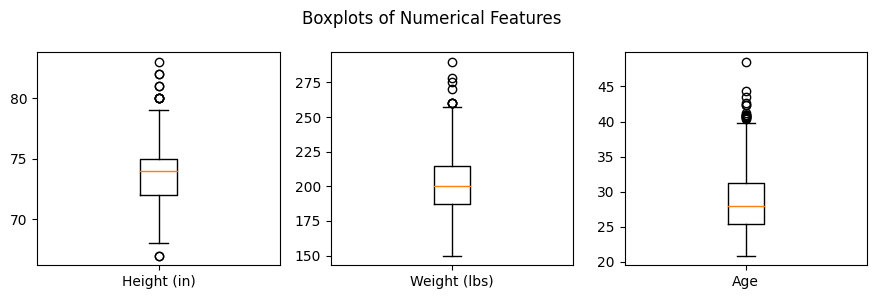

In [17]:
# boxplots of numerical features
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

# pass data into boxplots
ax[0].boxplot(df['Height(inches)'], labels=['Height (in)'])
ax[1].boxplot(df['Weight(pounds)'], labels=['Weight (lbs)'])
ax[2].boxplot(df['Age'], labels=['Age'])
fig.suptitle('Boxplots of Numerical Features')

fig.tight_layout()

Both height and weight again appear normally distributed, with a handful of outliers. Age is skewed on the upper bound, with quite a few outliers above 40.

Let's take a closer look at the exact numbers behind the box plots.

In [18]:
# returns quartiles data for an array
def box_nums(series):
    median = np.percentile(series, 50)
    q3, q1 = np.percentile(series, [75 ,25])
    iqr = q3 - q1
    box_max = q3 + (1.5 * iqr)
    box_min = q1 - (1.5 * iqr)
    return [box_min, q1, median, q3, box_max]

In [19]:
# get quartile data for each numerical feature
numerical_features = ['Height(inches)', 'Weight(pounds)', 'Age']
box_data = [box_nums(df[series]) for series in numerical_features]
box_cols = ['min', 'q1', 'median', 'q3', 'max']

# place quartile data into dataframe
box_df = pd.DataFrame(box_data, columns=box_cols, index=numerical_features)
box_df

,min,q1,median,q3,max
Height(inches),67.50000,72.00,74.000,75.0000,79.50000
Weight(pounds),145.00000,187.00,200.000,215.0000,257.00000
Age,16.75125,25.44,27.925,31.2325,39.92125


For height, we have one outlier below the minimum (5'7.5") and several above the maximum (6'7.5"). Let's see who they are!

In [20]:
# Height outliers
df.loc[(df['Height(inches)'] < 67.5) | (df['Height(inches)'] > 79.5)]

,Team,Position,Height(inches),Weight(pounds),Age
Andrew_Sisco,CWS,Relief_Pitcher,81.0,260.0,24.13
Kyle_Snyder,BOS,Starting_Pitcher,80.0,220.0,29.47
Richie_Sexson,SEA,First_Baseman,80.0,237.0,32.17
Scott_Elarton,KC,Starting_Pitcher,80.0,240.0,31.02
Phil_Stockman,ATL,Relief_Pitcher,80.0,240.0,27.10
Randy_Johnson,ARZ,Starting_Pitcher,82.0,231.0,43.47
Jason_Hirsh,COL,Starting_Pitcher,80.0,250.0,25.02
Mark_Hendrickson,LA,Starting_Pitcher,81.0,230.0,32.69
Chris_Young,SD,Starting_Pitcher,82.0,250.0,27.77
Jon_Rauch,WAS,Relief_Pitcher,83.0,260.0,28.42


Ha! A reminder that a visualization doesn't show everything. There are quite a few more outliers than the boxplot suggested!

Let's look at the outliers for weight and age.

In [21]:
# Weight outliers
df.loc[(df['Weight(pounds)'] < 145) | (df['Weight(pounds)'] > 257)]

,Team,Position,Height(inches),Weight(pounds),Age
Andrew_Sisco,CWS,Relief_Pitcher,81.0,260.0,24.13
Bobby_Jenks,CWS,Relief_Pitcher,75.0,270.0,25.96
C.C._Sabathia,CLE,Starting_Pitcher,79.0,290.0,26.61
Chris_Britton,NYY,Relief_Pitcher,75.0,278.0,24.21
Frank_Thomas,TOR,Designated_Hitter,77.0,275.0,38.76
Boof_Bonser,MIN,Starting_Pitcher,76.0,260.0,25.38
Prince_Fielder,MLW,First_Baseman,72.0,260.0,22.81
Jon_Rauch,WAS,Relief_Pitcher,83.0,260.0,28.42


In [22]:
# Age outliers
df.loc[(df['Age'] < 16.75) | (df['Age'] > 39.9)]

,Team,Position,Height(inches),Weight(pounds),Age
Curt_Schilling,BOS,Starting_Pitcher,77.0,235.0,40.29
Tim_Wakefield,BOS,Starting_Pitcher,74.0,210.0,40.58
Mike_Timlin,BOS,Relief_Pitcher,76.0,210.0,40.97
Roberto_Hernandez,CLE,Relief_Pitcher,76.0,250.0,42.30
Kenny_Rogers,DET,Starting_Pitcher,73.0,211.0,42.30
Jose_Mesa,DET,Relief_Pitcher,75.0,232.0,40.77
Randy_Johnson,ARZ,Starting_Pitcher,82.0,231.0,43.47
Jeff_Conine,CIN,Outfielder,73.0,220.0,40.68
Julio_Franco,NYM,First_Baseman,73.0,188.0,48.52
Moises_Alou,NYM,Outfielder,75.0,220.0,40.66


## Correlations

Let's see if we can find any correlations in the data. We'll start with the numerical correlations.

In [23]:
df.corr(numeric_only=True)

,Height(inches),Weight(pounds),Age
Height(inches),1.00000,0.532150,-0.073670
Weight(pounds),0.53215,1.000000,0.158402
Age,-0.07367,0.158402,1.000000


Interesting. There's a moderate correlation between height and weight, but very low correlation between any numerical variable and age. Let's take a look at the graphs to see more.

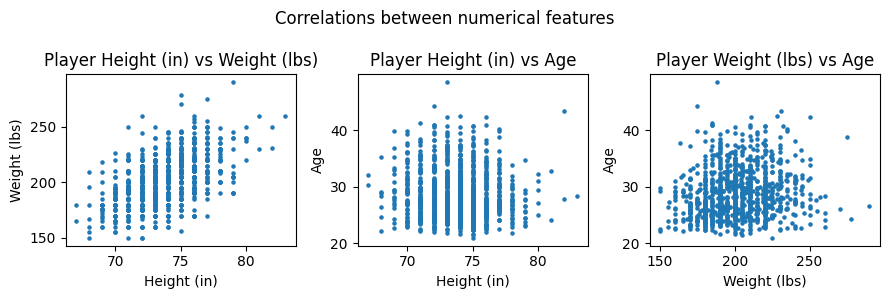

In [24]:
# scatterplot graphs for correlations between height, weight, and age
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# WITH SEABORN
# sns.set_style('whitegrid')
# sns.scatterplot(ax=axs[0], x=df['Height(inches)'], y=df['Weight(pounds)'])
# sns.scatterplot(ax=axs[1], x=df['Height(inches)'], y=df['Age'])
# sns.scatterplot(ax=axs[2], x=df['Weight(pounds)'], y=df['Age'])

# pass data into scatterplots
axs[0].scatter(x=df['Height(inches)'], y=df['Weight(pounds)'], s=5)
axs[1].scatter(x=df['Height(inches)'], y=df['Age'], s=5)
axs[2].scatter(x=df['Weight(pounds)'], y=df['Age'], s=5)

# labels, titles
x_labels = ['Height (in)', 'Height (in)', 'Weight (lbs)']
y_labels = ['Weight (lbs)', 'Age', 'Age']
for i in range(3):
    axs[i].set_xlabel(x_labels[i])
    axs[i].set_ylabel(y_labels[i])
    axs[i].set_title(f'Player {x_labels[i]} vs {y_labels[i]}')
fig.suptitle('Correlations between numerical features')

fig.tight_layout()

Our graphs agree with our correlations. There's a slight correlation between height and weight, but not between Age and the other numerical features.

## Feature Engineering (BMI)

We know that being an athlete requires a player to be in peak physical condition. Let's calculate player BMIs and see what that distribution looks like, and if there are any who are "overweight".

$$ BMI = kg_{weight} / m_{height} ^2 $$

In [25]:
# new column BMI
lbs_to_kg = 0.453592
in_to_m = 0.0254
df['BMI'] = (df['Weight(pounds)'] * lbs_to_kg) / (df['Height(inches)'] * in_to_m)**2

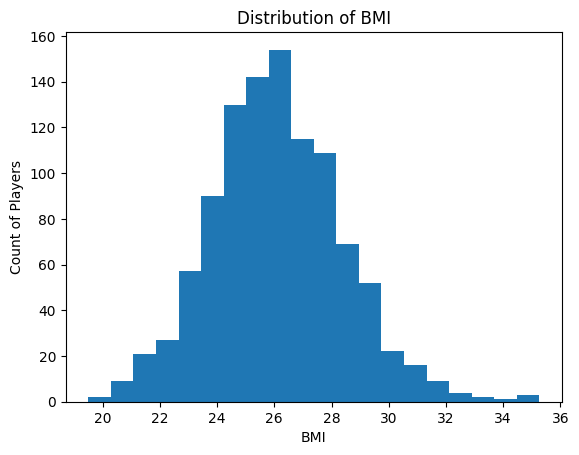

In [26]:
# distribution of BMI
plt.hist(df['BMI'], bins=20)
plt.xlabel('BMI')
plt.ylabel('Count of Players')
plt.title('Distribution of BMI')
plt.show()

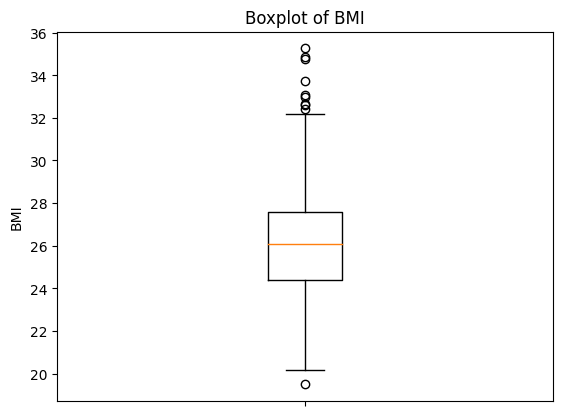

In [27]:
# boxplot of BMI
plt.boxplot(df['BMI'], labels=[''])
plt.ylabel('BMI')
plt.title('Boxplot of BMI')
plt.show()

For BMI: <br>
Underweight = <18.5 <br>
Normal weight = 18.5–24.9 <br>
Overweight = 25–29.9 <br>
Obesity = BMI of 30 or greater

It is safe to assume that the extra weight is due less to fat content and more to muscle content, but it is interesting to see the median BMI fall into the "overweight" category, and quite a few players are categorized as "obese"!

## Further Analysis

Despite our varying sample sizes for Position, let's compare them for height, weight, and age.

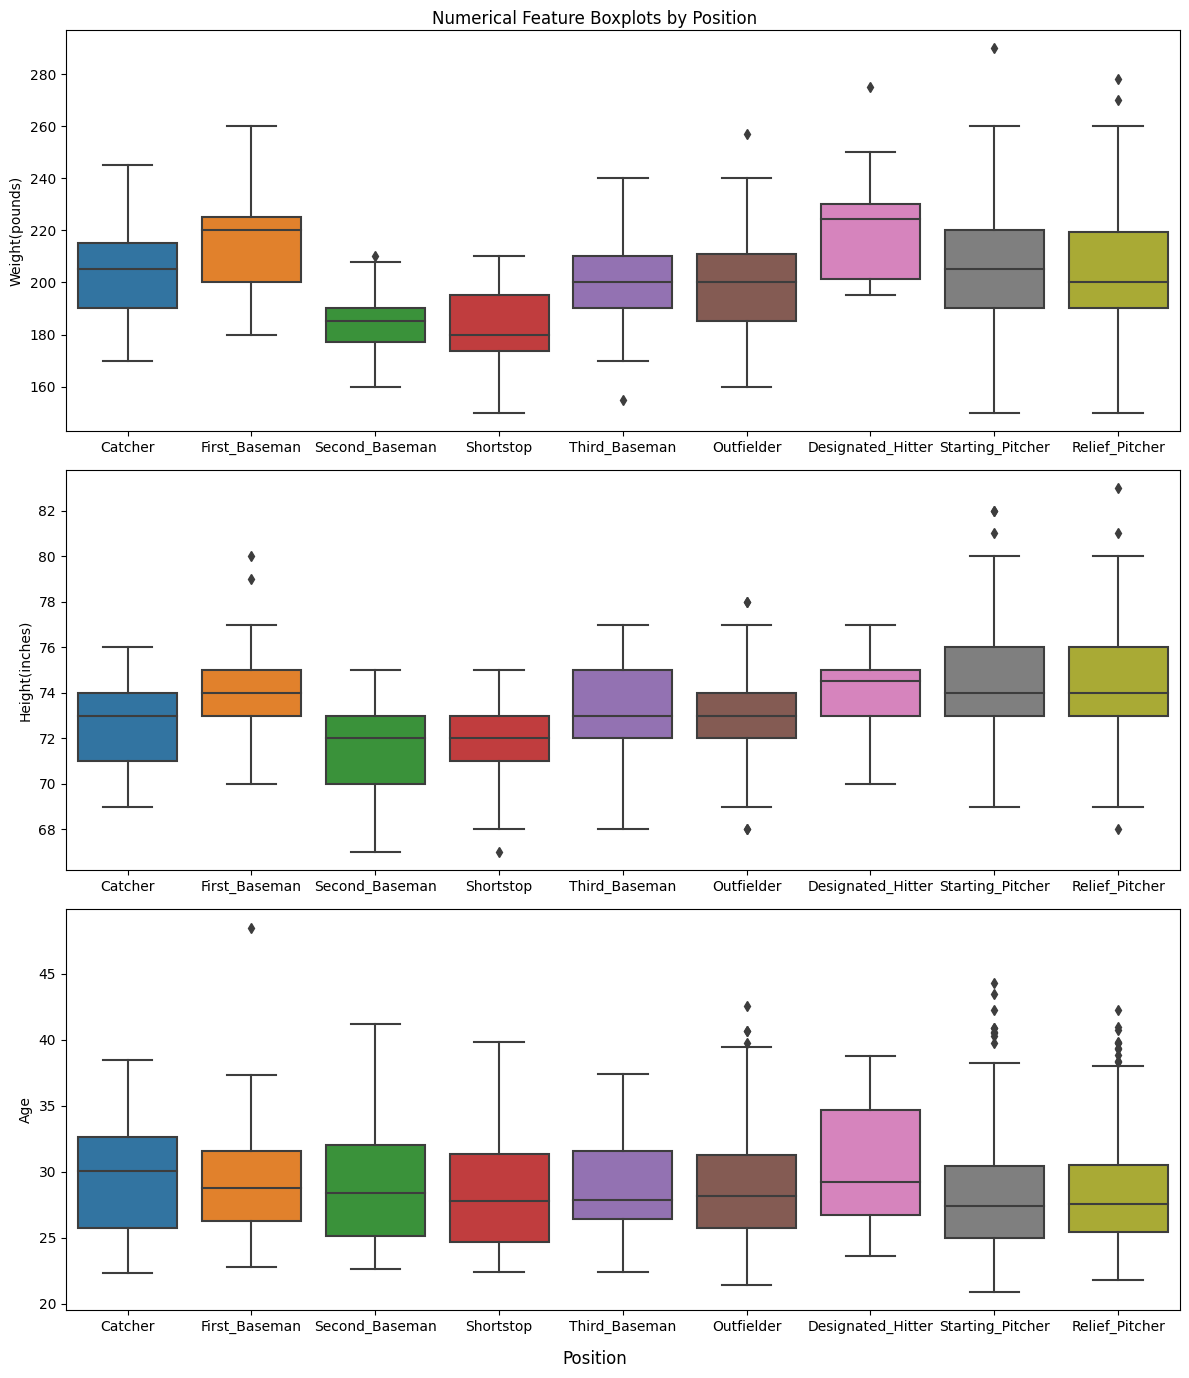

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(12, 14))

# pass data into boxplots
sns.boxplot(ax=axs[0], data=df, x='Position', y='Weight(pounds)').set(xlabel='')
sns.boxplot(ax=axs[1], data=df, x='Position', y='Height(inches)').set(xlabel='')
sns.boxplot(ax=axs[2], data=df, x='Position', y='Age').set(xlabel='')

#labels
fig.suptitle('Numerical Feature Boxplots by Position')
fig.supxlabel('Position')

fig.tight_layout()

From the Position groups, it appears that Second_Baseman and Shortstop are, on average, both lighter and shorter than the other Positions. Let's take a look at those!

In [29]:
# height & weight data for Second_Baseman and Shortstop
sb_weight = df.loc[df['Position'] == 'Second_Baseman']['Weight(pounds)']
ss_weight = df.loc[df['Position'] == 'Shortstop']['Weight(pounds)']
sb_height = df.loc[df['Position'] == 'Second_Baseman']['Height(inches)']
ss_height = df.loc[df['Position'] == 'Shortstop']['Height(inches)']

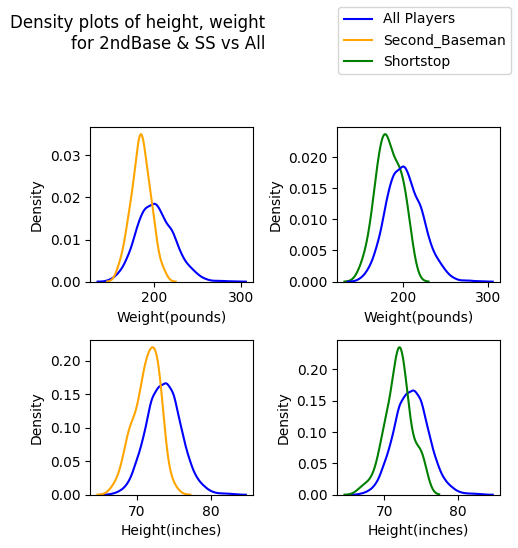

In [30]:
# plot normalized histograms (density) for height & weight of
    # Second_Baseman and Shortstop vs All Players
fig, axs = plt.subplots(2, 2, figsize=(5, 5.5))

# pass data into density plots
sns.kdeplot(ax=axs[0][0], data=df['Weight(pounds)'], color='blue')
sns.kdeplot(ax=axs[0][0], data=sb_weight, color='orange')
sns.kdeplot(ax=axs[0][1], data=ss_weight, color='green')
sns.kdeplot(ax=axs[0][1], data=df['Weight(pounds)'], color='blue')
sns.kdeplot(ax=axs[1][0], data=df['Height(inches)'], color='blue')
sns.kdeplot(ax=axs[1][0], data=sb_height, color='orange')
sns.kdeplot(ax=axs[1][1], data=df['Height(inches)'], color='blue')
sns.kdeplot(ax=axs[1][1], data=ss_height, color='green')

# legend, title
fig.legend(['All Players', 'Second_Baseman', 'Shortstop'])
fig.suptitle('Density plots of height, weight\nfor 2ndBase & SS vs All', ha='right',)

fig.tight_layout(rect=(0, 0, 1, 0.9))

We can see that the height and weight distributions for both Second_Baseman and Shortstop are lower on their respective scalars compared to All Players! Let's see if they're statistically significant.

## Hypothesis Testing

### Significance Tests for Height and Weight of Second Basemen and Shortstops

To test for statistical significance between our height and weight mean for Second_Baseman and Shortstop compared to the height and weight means of All Players, we will employ a low-tailed one-sample t-test. The tests are:

The Second_Baseman mean weight is significantly lower than the mean weight of All Players. <br>
$H_0 : \mu_{sbw} = \mu_{allw}$ <br>
$H_1 : \mu_{sbw} < \mu_{allw}$ <br>

The Second_Baseman mean height is significantly lower than the mean height of All Players. <br>
$H_0 : \mu_{sbh} = \mu_{allh}$ <br>
$H_1 : \mu_{sbh} < \mu_{allh}$ <br>

The Shortstop mean weight is significantly lower than the mean weight of All Players. <br>
$H_0 : \mu_{ssw} = \mu_{allw}$ <br>
$H_1 : \mu_{ssw} < \mu_{allw}$ <br>

The Shortstop mean height is significantly lower than the mean height of All Players. <br>
$H_0 : \mu_{ssh} = \mu_{allh}$ <br>
$H_1 : \mu_{ssh} < \mu_{allh}$ <br>

with a significance level of $\alpha = 0.05$

In [31]:
# weight means
all_weight_mu = df['Weight(pounds)'].mean()
sb_weight_mu = sb_weight.mean()
ss_weight_mu = ss_weight.mean()

# height means
all_height_mu = df['Height(inches)'].mean()
sb_height_mu = sb_height.mean()
ss_height_mu = ss_height.mean()

# mu values comparison
print([all_weight_mu, sb_weight_mu, ss_weight_mu])
print([all_height_mu, sb_height_mu, ss_height_mu])

[201.67311411992264, 184.3448275862069, 182.92307692307693]
[73.6972920696325, 71.36206896551724, 71.90384615384616]


From a cursory glance, we can say that our weight means for Second_Baseman and Shortstop are probably significantly lower than the mean weight for All Players. But for height, the results are unclear. Let's test!

In [32]:
# t tests
_, sbw_p = ttest_1samp(sb_weight, all_weight_mu, alternative='less')
_, sbh_p = ttest_1samp(sb_height, all_height_mu, alternative='less')
_, ssw_p = ttest_1samp(ss_weight, all_weight_mu, alternative='less')
_, ssh_p = ttest_1samp(ss_height, all_height_mu, alternative='less')

# show p-values (test results)
print(sbw_p, sbh_p, ssw_p, ssh_p)

1.638613594569169e-17 3.0055501939995607e-15 6.586093746088512e-13 1.3122764965394137e-09


Indeed, all of our results are below the $\alpha = 0.05$ significance level. We can reject the null hypothesis for all tests and claim:

The Second_Baseman mean weight is significantly lower than the mean weight of All Players. <br>
The Second_Baseman mean height is significantly lower than the mean height of All Players. <br>
The Shortstop mean weight is significantly lower than the mean weight of All Players. <br>
The Shortstop mean height is significantly lower than the mean height of All Players.

It's worth noting that this was not the most rigorous testing environment.

- The distributions are not (exactly) normally distributed.
- Our samples were of different sizes, and small (~50)
- We were not making a generalization about ALL second basemen or ALL shortstops, just those within our sample, and compared to our sample data.

### Weight of Players vs Average Male American (20 - 50 years)

While it is tempting to run a test comparing weights of MLB players to the average male American, it would not be a fair comparison. MLB player weight likely comes from muscle, not fat, while average male American weight is the opposite. We do not have enough metabolic data to differentiate what is contributing to the weight of an MLB player vs the average male American.

### Height of Players vs Average Male American (20 - 50 years)

The mean height of All Americans 20+, according to [this source](https://www.disabled-world.com/calculators-charts/height-chart.php#:~:text=The%20average%20height%20for%20American,or%205%27%209%22%20tall.) is 176.3cm. While the comparison is not perfectly rigorous (the source average probably includes males older than 50) it should serve as a fair estimation for a t-test.

Our dataset is a sample of American MLB players. While this may not be a recent set of players, it is (theoretically) a representative sample of MLB players, so we can safely make a generalization about MLB player height vs average American male height from this test.

Since we know the mean height of the players in this dataset is 73.7in (187.2cm), taller than the average male American, we will employ a high-tailed one-sample t-test. The test is:

The mean height of MLB players is significantly higher than the mean height of American males 20+. <br>
$H_0 : \mu_{MLBh} = \mu_{aAh}$ <br>
$H_1 : \mu_{MLBh} > \mu_{aAh}$ <br>

with a significance level of $\alpha = 0.05$.

In [33]:
# average American male 20+ height (inches)
aAh = 69.41

# t test
_, MLBh_p = ttest_1samp(df['Height(inches)'], aAh, alternative='greater')

# show p values (test result)
print(MLBh_p)

0.0


Exactly zero is a suspicious value. Obviously, if this test is true, then the calculated value is so small that it is being "rounded down".

However, since we know we are comparing the same units (aAh was converted to inches), our confidence lies in the validity of ttest_1samp (which we are very confident in). We can reject the null hypothesis and claim:

The mean height of MLB players is significantly higher than the mean height of American males 20+.

## Summary

In this notebook, we gathered a sample of 1034 records of MLB players' Team, Position, Height, Weight, and Age. 

We found that the distribution of player heights was Normal with a mean of 73.6 and a standard deviation of 2.3. The distribution of player weights was normal, with some outliers on the high side. The distribution of player ages was right-tailed, with most players between 25 and 31 years of age.

We found a number of outliers in heights, weights, and ages, with age outliers being 40+ years old.

We did not find any strong correlations between the features. The correlation between height and weight was the highest with a correlation value of 0.53.

We calculated BMI for each player, and found from the BMI distribution that many players were categorized as overweight or obese, but we deemed that this is likely due to muscle mass, not fat.

We compared boxplots of players separated by their Position, and found that Second Basemen and Shortstops were lighter and shorter than the average player.

We confirmed our hypotheses about Second Basemen and Shortstops in low-tailed one-sample t-tests.

We ran an additional hypothesis test comparing the height of MLB players to heights of average American males and found that MLB players were statistically significantly taller.